# Lesson 2

At this point we have a basic model based on logistic regression, and we've generated a first set of predictions.
In this lesson, we'll explore several ways to improve the model:

* Scaling

* Regularizing

* Adding categorical features

But we'll start by taking a closer look at the results from the previous model.
Let's load the data again.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
if not os.path.exists("utils.py"):
    !wget https://raw.githubusercontent.com/drivendataorg/tutorial-flu-shot-learning/main/utils.py

In [3]:
from utils import download_data_files

download_data_files()

In [4]:
labels_df = pd.read_csv("training_set_labels.csv", index_col="respondent_id")
features_df = pd.read_csv("training_set_features.csv", index_col="respondent_id")
test_features_df = pd.read_csv("test_set_features.csv", index_col="respondent_id")

In [5]:
# this won't be necessary in later versions
from sklearn import set_config
set_config(display="diagram")

Now let's rebuild the `Pipeline` from the previous lesson.

In [6]:
numeric_features_df = features_df.select_dtypes(include=np.number)
numeric_cols = numeric_features_df.columns

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model2 = Pipeline(
    [
        ("selector", ColumnTransformer([("numeric", "passthrough", numeric_cols)])),
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("classifier", LogisticRegression()),
    ]
)

In [8]:
y_true = labels_df["h1n1_vaccine"]

model2.fit(features_df, y_true)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chron...tion', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object'))])),
                ('imputer', SimpleImputer()),
                ('classifier', LogisticRegression())])

In [9]:
y_pred = model2.predict_proba(features_df).T[1]


In [10]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.8301287538133717

## Calibration

In the previous lesson we computed AUC scores because that's the metric the competition uses, but it is not the only way to quantify the performance of the model.
In fact, there are many metrics, each used to evaluate different aspects of the model.

One that is particularly useful for binary classification is the **calibration curve**, which checks whether the probilities generated by the model are consistent with the true labels.

If we look at a single prediction, it is hard to tell whether it is right. For example, if the model predicts that a particular respondent has a 70% chance of being vaccinated, and in fact they were vaccinated, was the model right? Of if they were not vaccinated, was the model wrong? It's hard to say.

But suppose there are 100 respondents who were given a probability near 70%. If 70 of them were actually vaccinated, we would say that the predictive probability was well **calibrated**.
If it only 50 of them were actually vaccinated, or 90, we would be less impressed.

Now suppose we group the respondents into bins according to their predicted probabilities. In the first bin, we might put everyone with probability less than 10%. In the next bin, everyone with probability between 10% and 20%, and so on.
Then for each group, we could compute the actual percentage who are vaccinated.
If we plot these results, with the bins on the x-axis and the actual percentages on the y-axis, the result is a calibration curve.

Scikit-learn provides a function that computes calibration curves.

In [11]:
from sklearn.calibration import calibration_curve

# In version 1.1 we would use `pos_label` to be explicit
# x, y = calibration_curve(y_true, y_pred, pos_label=1, n_bins=10)

x, y = calibration_curve(y_true, y_pred, n_bins=10)

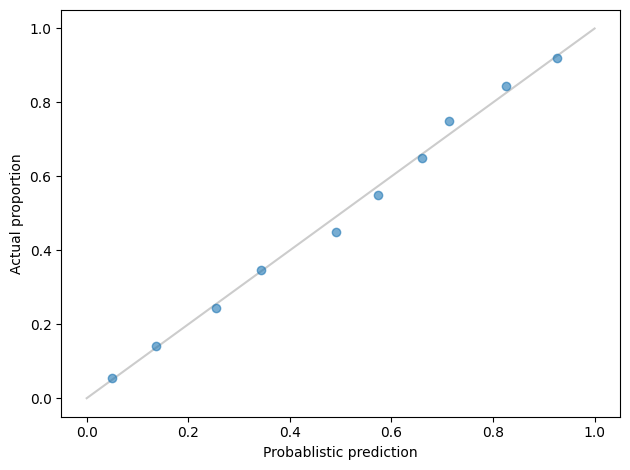

In [12]:
from utils import decorate

plt.plot([0, 1], [0, 1], color="gray", alpha=0.4)
plt.plot(x, y, "o", alpha=0.6)
decorate(xlabel="Probablistic prediction", ylabel="Actual proportion")

The markers show the results, one for each bin. The gray line is where the actual proportions equal the predicted probabilities. When a marker falls on the line, that means the predictions in that bin were well calibrated.
Overall, these results are pretty good: over the entire range, the actual proportions are close to the predicted probabilities.

## Scaling

Now let's get back to the model and see where we can make improvements.

In the previous lesson, I mentioned one reason we could not interpret the coefficients of the model: the features are not on the same scales.
For example, `behavioral_wash_hands` is either 0 or 1, `h1n1_concern` is on a scale from 0 to 3, and `opinion_h1n1_vacc_effective` is on a scale from 0 to 5.

In [13]:
features_df.describe().loc[["min", "max"]]

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
max,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0


For this reason, and another I will explain soon, it is generally a good idea to scale features before fitting a model. We can do that by adding one more stage to the `Pipeline`.

In [14]:
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline(
    [
        ("selector", ColumnTransformer([("selector", "passthrough", numeric_cols)])),
        ("scaler", StandardScaler()),  # this line is new
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("classifier", LogisticRegression()),
    ]
)

We can use this `Pipeline` as we did in the previous chapter, but for the sake of convenience, I'll introduce one more tool, the `MultiOutputClassifier`.

Since we are using the same set of features to predict multiple labels, this is an example of a **multi-output classification** problem.
Rather than build two pipelines explicitly, as we did in the previous lesson, we can create a classifier like this:

In [15]:
from sklearn.multioutput import MultiOutputClassifier

classifier = MultiOutputClassifier(estimator=LogisticRegression())

A `MultiOutputClassifier` is a container that holds multiple `LogisticRegression` objects.
We can use it as a classifier in a pipeline like this:

In [16]:
model3 = Pipeline(
    [
        ("selector", ColumnTransformer([("selector", "passthrough", numeric_cols)])),
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("classifier", classifier),  # this line has changed
    ]
)

Now we can generate predictions for both labels at the same time.

In [17]:
model3.fit(features_df, labels_df)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chro...
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object'))])),
                ('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression()))])

The result from `predict_proba` is a list of two arrays, one for each target variable.

In [18]:
pred1, pred2 = model3.predict_proba(features_df)
pred1

array([[0.97088505, 0.02911495],
       [0.7266493 , 0.2733507 ],
       [0.94943016, 0.05056984],
       ...,
       [0.73727762, 0.26272238],
       [0.99058945, 0.00941055],
       [0.86154527, 0.13845473]])

Each array has two columns, one for each class (vaccinated or not). So, again, we'll select the second column, which is the predicted probability of vaccination.

In [19]:
y_pred1 = pred1.T[1]
y_true1 = labels_df["h1n1_vaccine"]
roc_auc_score(y_true, y_pred1)

0.8301349377610803

In [20]:
y_pred2 = pred2.T[1]
y_true2 = labels_df["seasonal_vaccine"]
roc_auc_score(y_true2, y_pred2)

0.8329153442069163

In this example, scaling the inputs has a very small effect on the score, but it is generally good practice, particularly because it is necessary for proper regularization, which is the next topic.

But before we go on, let's put that scoring code into a function.
The return value is the average of the two AUC scores.

In [21]:
def score_model(model, features_df, labels_df):
    """Compute the average AUC score for the two labels.

    Args:
        model: A fitted Sklearn model
        features_df: DataFrame of features
        labels_df: DataFrame of labels

    Returns: float AUC score
    """

    pred1, pred2 = model.predict_proba(features_df)

    y_pred1 = pred1.T[1]
    score1 = roc_auc_score(labels_df["h1n1_vaccine"], y_pred1)

    y_pred2 = pred2.T[1]
    score2 = roc_auc_score(labels_df["seasonal_vaccine"], y_pred2)

    return (score1 + score2) / 2

In [22]:
score_model(model3, features_df, labels_df)

0.8315251409839983

## Regularizing

The behavior of the `LogisticRegression` classifier is controlled by several parameters, which we can display like this.

In [23]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

The one we'll look at now is `penalty`, which specifies what kind of regularization the classifier uses.
In general, **regularization** is an adjustment to the model-fitting process intended to avoid overfitting.
The value `l2` specifies L2 regularization, also known as **ridge regression**.

L2 regression penalizes models with large coefficients, so if it compares two models where one is a little more accurate and the other has smaller coefficients, it might choose the second.
The parameter `C` controls the size of the penalty, but it's inverted, so a smaller value of `C` means a bigger penalty; that is, the classifier is willing to sacrifice more accuracy to get smaller coefficients.

Why, you might wonder, do we care about the size of the coefficients, and why should we be willing to sacrifice accuracy to make them smaller?

The underlying assumption is that some features add predictive value and other are effectively random. 
A good model should include the most valuable features and leave out the random ones. 
A model that includes all of the parameters is likely to be overfit; that is, it has probably learned details of the training data that will not make the predictions on the test data better, and might make them worse.

L2 regularization reduces the influence of non-predictive features by pushing their coefficients toward zero.
An alternative is L1 regularization, which takes this idea even farther; if it can remove a feature from the model entirely, without sacrificing too much accuracy, it will.

The following example creates a `LogisticRegression` classifier with L1 regularization and `C` set to 0.01, which indicates a strong penalty.
With this parameter, we also need to provide a `solver`, which selects one of the model-fitting algorithms that can do L1 regularization.

In [24]:
from sklearn.multioutput import MultiOutputClassifier

classifier = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l1", C=0.01, solver="saga")
)

In [25]:
model4 = Pipeline(
    [
        ("selector", ColumnTransformer([("selector", "passthrough", numeric_cols)])),
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("classifier", classifier),
    ]
)

In [26]:
model4.fit(features_df, labels_df)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chro...
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object'))])),
                ('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(C=0.01,
                                                                    penalty='l1',
                                                                    solver='saga')))])

Pipelines are convenient in many ways, but they don't make it easy to find the estimated coefficients!
Nevertheless, here they are:

In [27]:
classifier1, classifier2 = model4[-1].estimators_

In [28]:
classifier1.coef_

array([[-0.0416895 ,  0.07479139,  0.        ,  0.        ,  0.01813788,
         0.        , -0.06325363,  0.        ,  0.        ,  0.74087242,
        -0.13113851,  0.02494237,  0.03549932,  0.21795986,  0.32981606,
         0.58189032,  0.4243108 ,  0.        ,  0.08038359,  0.18488816,
        -0.08710185,  0.        , -0.05000592]])

In [29]:
classifier2.coef_

array([[ 0.00506871,  0.10992433,  0.        ,  0.        ,  0.        ,
         0.01336472,  0.        ,  0.        ,  0.09764047, -0.08315271,
         0.65200461,  0.13902312,  0.        ,  0.19476556,  0.33684071,
         0.        ,  0.        , -0.05895702,  0.62377945,  0.68661686,
        -0.26877753, -0.06335977, -0.20480668]])

If the estimated coefficient for a feature is 0, that means the feature has been eliminated from the model.
For the two target variables, L1 regularization was able to eliminate 7 or 8 of the 23 coefficients.
The result is a simpler model in the sense that it uses fewer features.

Let's see how much accuracy we had to sacrifice for this simplicity. Here's the average accuracy with L2 regularization again:

In [30]:
score_l2 = score_model(model3, features_df, labels_df)
score_l2

0.8315251409839983

And with L1 regularization:

In [31]:
score_l1 = score_model(model4, features_df, labels_df)
score_l1

0.8308798267166294

With L1 regularization, the average AUC score is slightly lower than with L2 regularization, but the difference is very small, and we expect the model with L1 regularization to be less prone to overfitting.
So, even if it is less good on the training data, it might be better on the test data.
Or even if it isn't, the score on the training data should provide a more realistic expectation for the score on the test data.

However, in this example, overfitting is not a big problem.
`LogisticRegression` models have a relatively small number of coefficients, compared to other models we'll see soon, so they are generally less prone to overfitting. 

**Exercise:** If you are not sure which is better, L1 or L2 regularization, "¿Por qué no los dos?"

`LogisticRegression` provides yet another penalty, called `elasticnet`, which includes both L1 and L2 penalties. Again, the parameter `C` controls the weight of the penalties, and a second parameter, `l1_ratio`, divides the weight between L1 and L2. When `l1_ratio` is `1`, ElasticNet is the same as L1 regularization; when it is `0`, ElasticNet is the same as L2 regularization.

Make a pipeline that uses `LogisticRegression` with `ElasticNet` and try a few values for the parameters. Can you find a combination of `C` and `l1_ratio` that maximizes the AUC score on the training data?

Keep in mind that the optimal parameters for the training data are not necessarily optimal for the test data. So this exercise might not demonstrate good practice. We'll see a better alternative in the next lesson.

In [32]:
# Solution

from sklearn.multioutput import MultiOutputClassifier

classifier = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga")
)

In [33]:
# Solution

model_en = Pipeline(
    [
        ("selector", ColumnTransformer([("selector", "passthrough", numeric_cols)])),
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("classifier", classifier),
    ]
)

In [34]:
# Solution

model_en.fit(features_df, labels_df)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chro...
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object'))])),
                ('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(l1_ratio=0.5,
                                                                    penalty='elasticnet',
                                                                    solver='saga')))])

In [35]:
# Solution

scores_en = score_model(model_en, features_df, labels_df)
scores_en

0.8315263500618354

## Categorical features

So far we've used only numerical features, but the dataset also includes several categorical features, including sex, race, age group, and level of education.
It is plausible that any of these could have predictive value, so let's get them into the model.

As an example, let's consider `education`, which has the following values, including `NaN` for missing data.

In [36]:
features_df["education"].value_counts(dropna=False)

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
NaN                  1407
Name: education, dtype: int64

One way to include a categorical feature in a model is **one-hot encoding**, which replaces a categorical feature with several binary numerical features, one for each value.
An example will make that clearer.

Scikit-learn provides an object called `OneHotEncoder`:

In [37]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

Before we can use it, we have to give it some data to "fit". During this step, it learns what the possible values are for each categorial variable.

In [38]:
categoric_features_df = features_df[["education"]]

encoder.fit(categoric_features_df)
encoder.categories_

[array(['12 Years', '< 12 Years', 'College Graduate', 'Some College', nan],
       dtype=object)]

Now we can use it to transform the original values.

In [39]:
matrix = encoder.transform(categoric_features_df)
matrix

<26707x5 sparse matrix of type '<class 'numpy.float64'>'
	with 26707 stored elements in Compressed Sparse Row format>

The result is a NumPy sparse matrix, which is an efficient way to represent an array where many of the elements are zero.
To see what the matrix looks like, we can convert it to an array:

In [40]:
array = matrix.toarray()
array

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

The encoded data has five columns, one for each level of education.
We can see that more clearly by putting the results in a DataFrame.

In [41]:
pd.DataFrame(array, columns=encoder.categories_).head()

,12 Years,< 12 Years,College Graduate,Some College,NaN
0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In each row, exactly one of the elements is "hot", which is to say 1. The others are "cold", which is to say 0.

In [42]:
(array.sum(axis=1) == 1).all()

True

If we compare the original values with the encoded values, we can check that they agree.
For example, here are the first few rows of the original feature.

In [43]:
features_df["education"].head()

respondent_id
0          < 12 Years
1            12 Years
2    College Graduate
3            12 Years
4        Some College
Name: education, dtype: object

The first respondent has less than 12 years of education; in the encoded array, we can see that the second column in the first row is hot. The second respondent has 12 years, and we can see that the first column is hot. So that checks out.

When these columns are passed to `LogisticRegression`, it estimates a coefficient for each column, which quantifies the relationship between each level of education and the target variables.

Now we're ready to combine the categorical and numerical features in a single model.
For the numerical variables, we'll use the same pipeline we've used before.

In [44]:
numeric_pipeline = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("simple_imputer", SimpleImputer(strategy="mean")),
    ]
)

In the previous lesson, we selected the numeric features like this:

In [45]:
numeric_features_df = features_df.select_dtypes(include=np.number)
numeric_cols = numeric_features_df.columns

We can select the categorical features like this:

In [46]:
categoric_features_df = features_df.select_dtypes(include=np.object_)
categoric_cols = categoric_features_df.columns

We'll combine the two sets of features with a `ColumnTransformer`.

In [47]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categoric", OneHotEncoder(), categoric_cols),
    ]
)

The `transformers` argument is a list of tuples, where each tuple contains a string name for this part of the pipeline, a `Pipeline` object, and a list of column names that should be processed with this pipeline.

The preprocesing pipeline is complete; now we need a classifier. We'll use `LogisticRegression` again, with a few additional parameters.

In [48]:
classifier = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", solver="saga", max_iter=200, tol=1e-3)
)

As the model gets more complex, it becomes harder for the solver to find the best coefficients. I've increased `max_iter` to allow it to take additional iterations, and I've adjusted `tol` so it doesn't spend more time than needed to make the coeffients precise.

Finally, here's the complete model.

In [49]:
model5 = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", classifier),
    ]
)

We can fit the model in the usual way.

In [50]:
model5.fit(features_df, labels_df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer())]),
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outsid...
      dtype='object')),
                                                 ('categoric', OneHotEncoder(),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=200,
                                                                    solver='saga',
                                                                    tol=0.001)))])

And compute a score on the training data.

In [51]:
score_model(model5, features_df, labels_df)

0.8474823438528167

Adding the categorical variables improves the model a little, at least on the training data.

## Submit the predictions

Now that the categorical variables are in the model, let's see if our score is better on the test data.
I'll use this function to prepare a submission:

In [52]:
def make_submission(model, test_features_df):
    """Make a DataFrame ready for submisstion to the competition.

    Args:
        model: fitted Scikit-learn model
        test_features_df: DataFrame of features

    Returns: DataFrame of predicted probabilities
    """
    pred1, pred2 = model.predict_proba(test_features_df)
    d = dict(h1n1_vaccine=pred1.T[1], seasonal_vaccine=pred2.T[1])
    return pd.DataFrame(d, index=test_features_df.index)

In [53]:
make_submission(model5, test_features_df).to_csv("submission2.csv")

In [54]:
if "google.colab" in sys.modules:
    from google.colab import files
    files.download("submission2.csv")

When I submitted these predictions on the competition site, the AUC score was 0.8355.
That's an improvement on the previous score, using numeric data only, which was 0.8204.
It's not as big an improvement as we might have hoped, which suggests that the categorical variables don't have much predictive value that was not already captured by the numerical variables.

## Ordinal variables

Some categorical variable are **ordinal**, which means that there is some natural way to put their values in order.
In this dataset, `age_group` is an ordinal categorical variable with the following values:

In [55]:
features_df["age_group"].value_counts().sort_index()

18 - 34 Years    5215
35 - 44 Years    3848
45 - 54 Years    5238
55 - 64 Years    5563
65+ Years        6843
Name: age_group, dtype: int64

If we treat an ordinal variable as a plain old categorical variable, we don't use all of the information we have: the model "knows" that the age groups are different, but it does not know that they represent a sequence of ages.
If older people are consistently more likely to get vaccinated (or less likely), the model might be more accurate if it knows the order of the categories.

To do that, we can use the `OrdinalEncoder` instead of the `OneHotEncoder`, and specify the categories in appropriate order.

In [56]:
from sklearn.preprocessing import OrdinalEncoder

age_group_categories = [
    "18 - 34 Years",
    "35 - 44 Years",
    "45 - 54 Years",
    "55 - 64 Years",
    "65+ Years",
]
encoder = OrdinalEncoder(categories=[age_group_categories])
encoder.fit(features_df[["age_group"]])

OrdinalEncoder(categories=[['18 - 34 Years', '35 - 44 Years', '45 - 54 Years',
                            '55 - 64 Years', '65+ Years']])

Now we can use the encoder to transform the feature from categories to numbers.

In [57]:
encoder.transform(features_df[["age_group"]])

array([[3.],
       [1.],
       [0.],
       ...,
       [3.],
       [0.],
       [4.]])

We can do the same thing with `education`, with one additional step. Because this variable contains some missing values, represented by the special value `NaN`, we have to tell the encoder how to handle missing values.
In this case, we'll replace `NaN` with `-1`.

In [58]:
education_categories = ["< 12 Years", "12 Years", "Some College", "College Graduate"]

In [59]:
encoder = OrdinalEncoder(
    categories=[education_categories],
    unknown_value=-1,
    handle_unknown="use_encoded_value",
)
encoder.fit(features_df[["education"]])

OrdinalEncoder(categories=[['< 12 Years', '12 Years', 'Some College',
                            'College Graduate']],
               handle_unknown='use_encoded_value', unknown_value=-1)

Here's what the transformed values look like.

In [60]:
from utils import value_counts

values = encoder.transform(features_df[["education"]])
value_counts(values.flatten(), dropna=False)

 3.0    10097
 2.0     7043
 1.0     5797
 0.0     2363
-1.0     1407
dtype: int64

If we add these values to a model, it would treat missing values as if they represented less education than a high school diploma, which is probably not valid.
To correct that, we can add a binary variable that indicates whether the `education` value is missing.
If the missing status has any predictive value, this feature will allow the model to estimate it.

In [61]:
features_df["education_missing"] = features_df["education"].isna().astype(int)
value_counts(features_df["education_missing"])

0    25300
1     1407
Name: education_missing, dtype: int64

Rather than add the indicator variable by hand, you could add to the ordinal pipeline a `SimpleImputer` with the argument `add_indicator=True`. But I'll leave that as an exercise.

Now let's get these steps into the pipeline. First, we'll split the categorical variables into non-ordinal and ordinal.

In [62]:
unordered_cols = [
    "race",
    "sex",
    "income_poverty",
    "marital_status",
    "rent_or_own",
    "employment_status",
    "hhs_geo_region",
    "census_msa",
    "employment_industry",
    "employment_occupation",
    "education_missing",
]

ordinal_cols = ["age_group", "education"]

Next we'll make a pipeline for the two ordinal variables.

In [63]:
categories = [age_group_categories, education_categories]

ordinal_encoder = OrdinalEncoder(
    categories=categories,
    unknown_value=-1,
    handle_unknown="use_encoded_value",
)

And assemble a ColumnTransformer that contains pipelines for numeric, categorical, and ordinal variables.

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categoric", OneHotEncoder(), unordered_cols),
        ("ordinal", ordinal_encoder, ordinal_cols),
    ]
)

**Exercise:** As an exercise, put `preprocessor` into a pipeline with a `MultiOutputClassifier` that contains your favorite `LogisticRegression` classifier.
Then fit the training data and compute the AUC score with the training data.
Does it make the model more accurate if we treat age and education as ordinal variables?

In [65]:
# Solution

classifier = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", solver="saga", max_iter=200, tol=1e-3)
)

In [66]:
# Solution

model_ord = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", classifier),
    ]
)

In [67]:
# Solution

model_ord.fit(features_df, labels_df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer())]),
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outsid...
                                                  OrdinalEncoder(categories=[['18 '
                                                                              '- '
                                                                              '34 '
                                                                              'Years',
                                                                              '35 '
                                                                              '- '
                                                                              '44 '
                                                                              'Years',
                                                                              '45 '
                                                                              '- '
                                                                              '54 '
                                                                              'Years',
                                                                              '55 '
                                                                              '- '
                                                                              '64 '
                                                                              'Years',
                                                                              '65+ '
                                                                              'Years'],
                                                                             ['< '
                                                                              '12 '
                                                                              'Years',
                                                                              '12 '
                                                                              'Years',
                                                                              'Some '
                                                                              'College',
                                                                              'College '
                                                                              'Graduate']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['age_group',
                                                   'education'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=200,
                                                                    solver='saga',
                                                                    tol=0.001)))])

In [68]:
# Solution

# On the training data, the model with ordinal features is no better.
# I haven't tried it on the test data.

score_model(model_ord, features_df, labels_df)

0.8466571076123897